In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Задание 1
df_reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
df_auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

In [3]:
df_reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
df_auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
# Проверим на дубликаты в данных
reg_data_duplicates = df_reg_data.duplicated().sum()
auth_data_duplicates = df_auth_data.duplicated().sum()
reg_data_duplicates, auth_data_duplicates

(0, 0)

In [6]:
# Проверим данные на пропуски
missing_values_reg = df_reg_data.isnull().sum()
missing_values_auth = df_auth_data.isnull().sum()
missing_values_reg, missing_values_auth 

(reg_ts    0
 uid       0
 dtype: int64,
 auth_ts    0
 uid        0
 dtype: int64)

In [7]:
# Объединим и проверим логику данных: есть ли регистрация позже, чем авторизация
merged_df = pd.merge(df_auth_data, df_reg_data, on='uid', how='inner')
# Преобразуем временные метки в формат datetime
merged_df['reg_ts'] = pd.to_datetime(merged_df['reg_ts'], unit='s')
merged_df['auth_ts'] = pd.to_datetime(merged_df['auth_ts'], unit='s')
logical_issues = (merged_df['auth_ts'] < merged_df['reg_ts']).sum()
logical_issues

0

In [8]:
# Данные корректные

In [20]:
# Функция для вычисления retention с когортным анализом
def calculate_cohort_retention(df, cohort_start=None, cohort_end=None):
    """
    Вычисляет удержание пользователей по когортам.
    
    Параметры:
    df (DataFrame): Данные, содержащие столбцы 'reg_ts', 'auth_ts', 'uid'.
    cohort_start (str): Начальная дата для когортного анализа
    cohort_end (str): Конечная дата для когортного анализа
    
    Возвращает:
    DataFrame: Таблица с удержанием пользователей по дням и когортам.
    """
    if cohort_start:
        df = df[df['reg_ts'] >= pd.to_datetime(cohort_start)]
    if cohort_end:
        df = df[df['reg_ts'] <= pd.to_datetime(cohort_end)]

    # Создаем столбцы с датой регистрации и днем удержания
    df['reg_date'] = df['reg_ts'].dt.date
    df['retention_day'] = (df['auth_ts'] - df['reg_ts']).dt.days

    # Считаем уникальных пользователей для каждой когорты по дням удержания
    cohort_data = df.groupby(['reg_date', 'retention_day']).agg({'uid': 'nunique'}).reset_index()
    
    # Считаем размер когорты по дате регистрации
    cohort_sizes = cohort_data[cohort_data['retention_day'] == 0][['reg_date', 'uid']].rename(columns={'uid': 'cohort_size'})
    
    # Объединяем данные для расчета процента удержания
    cohort_data = pd.merge(cohort_data, cohort_sizes, on='reg_date')
    
    # Вычисляем процент удержания для каждой когорты по дням
    cohort_data['retention_rate'] = cohort_data['uid'] / cohort_data['cohort_size'] * 100
    
    # Преобразуем данные в формат для тепловой карты
    retention_matrix = cohort_data.pivot(index='reg_date', columns='retention_day', values='retention_rate')

    # Ограничиваем отображение первых 30 дней
    retention_matrix = retention_matrix.loc[:, 1:30]

    
    
    return retention_matrix

# Рассчитаем удержание за один месяц (например, за февраль 2020 года)
cohort_retention_matrix = calculate_cohort_retention(merged_df, cohort_start='2020-02-01', cohort_end='2020-02-29')



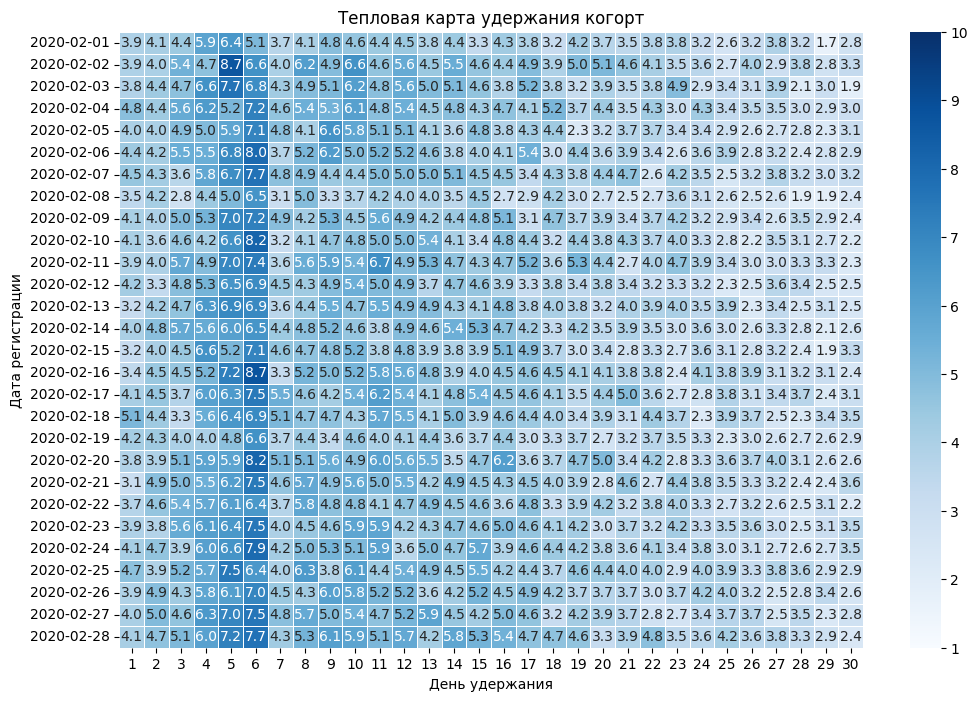

In [21]:
# Построим тепловую карту для наглядности удержания пользователей без 0 дня
plt.figure(figsize=(12, 8))

# Настроим цветовую палитру с фокусом на диапазон удержания от 1% до 10%
cmap = sns.color_palette("Blues", as_cmap=True)

sns.heatmap(cohort_retention_matrix, annot=True, fmt='.1f', cmap=cmap, linewidths=0.5, vmin=1, vmax=10)

plt.title('Тепловая карта удержания когорт')
plt.xlabel('День удержания')
plt.ylabel('Дата регистрации')

plt.show()


In [260]:
# Вывод
# В первые несколько дней после регистрации наблюдается заметное снижение удержания (примерно на 1-2% за каждый день),
# что типично для большинства пользователей. Удержание стабилизируется примерно на 3-5 дне.

# В период с 3 по 10 день удержание колеблется между 3-6%. Это говорит о том, что примерно 3-6%
# пользователей продолжают возвращаться к продукту спустя неделю после регистрации.

# Некоторые когорты демонстрируют более высокий уровень удержания на начальных этапах
# (например, пользователи, зарегистрировавшиеся 12 и 18 февраля, показывают удержание выше среднего на 7 и 8 дни).
# Это может быть связано с особенностями маркетинговых кампаний или взаимодействий с продуктом в эти дни.

# В целом, данные показывают типичный "классический" паттерн снижения удержания
# с постепенным выравниванием для небольшого процента лояльных пользователей.

In [261]:
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [262]:
# Задача 2
# Загрузим данные
df_ab = pd.read_csv('Проект_1_Задание_2.csv', sep=';')
df_ab.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [263]:
# Разделяем данные на контрольную и тестовую группы
control_group = df_ab[df_ab['testgroup'] == 'a']
test_group = df_ab[df_ab['testgroup'] == 'b']

In [264]:
# Вычисляем конверсии для каждой группы
control_conversions = len(control_group[control_group['revenue'] > 0])
test_conversions = len(test_group[test_group['revenue'] > 0])

In [265]:
control_total = len(control_group)
test_total = len(test_group)

In [266]:
# Рассчитываем коэффициент конверсии
control_conversion_rate = control_conversions / control_total
test_conversion_rate = test_conversions / test_total

In [267]:
# Мы сравниваем конверсии, которые представляют собой бинарную переменную (платит пользователь или нет),
# и для таких данных подходит Z-тест для пропорций.

In [268]:
# Выполняем Z-тест для пропорций (для проверки разницы конверсий)
conversion_z_stat, conversion_p_value = proportions_ztest([test_conversions, control_conversions],
                                                          [test_total, control_total])

In [269]:
# Рассчитываем ARPU для обеих групп
control_arpu = control_group['revenue'].mean()
test_arpu = test_group['revenue'].mean()
control_arpu,test_arpu

(25.413719736965806, 26.75128659327863)

In [24]:
# Используем t-тест для проверки разницы в среднем доходе на пользователя.
# t-тест выбран для проверки разницы ARPU, поскольку эта метрика представляет собой количественные данные,
# и мы сравниваем средние значения между двумя независимыми группами.
# t-тест эффективно выявляет различия в средних значениях при условии, что данные распределены нормально или имеют достаточно большую выборку,
# что снижает чувствительность к отклонениям от нормальности.

In [271]:
# Выполняем t-тест для проверки разницы в среднем доходе
arpu_t_stat, arpu_p_value = stats.ttest_ind(test_group['revenue'], control_group['revenue'])


In [272]:
# Выведим результаты
conversion_results = {
    'Control Conversion Rate': control_conversion_rate,
    'Test Conversion Rate': test_conversion_rate,
    'Conversion Z-Statistic': conversion_z_stat,
    'Conversion P-Value': conversion_p_value,
}

In [273]:
arpu_results = {
    'Control ARPU': control_arpu,
    'Test ARPU': test_arpu,
    'ARPU T-Statistic': arpu_t_stat,
    'ARPU P-Value': arpu_p_value,
}

In [274]:
print("Результаты по конверсии:", conversion_results)
print("Результаты по ARPU:", arpu_results)

Результаты по конверсии: {'Control Conversion Rate': 0.009539690157988749, 'Test Conversion Rate': 0.008906235351586593, 'Conversion Z-Statistic': -2.108028495889841, 'Conversion P-Value': 0.035028524642854865}
Результаты по ARPU: {'Control ARPU': 25.413719736965806, 'Test ARPU': 26.75128659327863, 'ARPU T-Statistic': 0.6242026493616787, 'ARPU P-Value': 0.532494858971837}


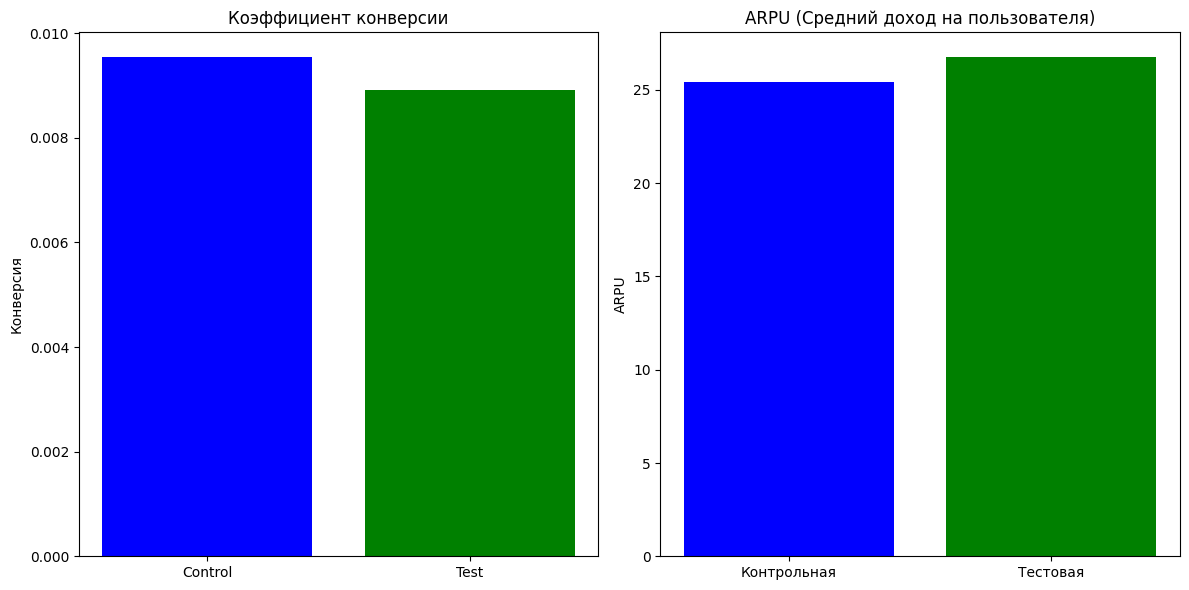

In [275]:
# Визуализируем для наглядности
# Создаем два графика для сравнения конверсии и ARPU
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# График конверсий
axes[0].bar(['Control', 'Test'], [control_conversion_rate, test_conversion_rate], color=['blue', 'green'])
axes[0].set_title('Коэффициент конверсии')
axes[0].set_ylabel('Конверсия')

# График ARPU
axes[1].bar(['Контрольная', 'Тестовая'], [control_arpu, test_arpu], color=['blue', 'green'])
axes[1].set_title('ARPU (Средний доход на пользователя)')
axes[1].set_ylabel('ARPU')

plt.tight_layout()
plt.show()

In [276]:
# Несмотря на то, что ARPU в тестовой группе выше на 5%, это различие не является статистически значимым.
# При этом конверсия в контрольной группе выше, и эта разница статистически значима. 

In [22]:
# Вывод:
# Таким образом Поскольку конверсия является важной метрикой, низкая конверсия в тестовой группе говорит о том, что тестовое предложение
# не стимулирует больший процент пользователей к совершению покупок. Это серьёзный аргумент в пользу того, что тестовый вариант
# не стоит раскатывать на всех.

In [23]:
# Повышение ARPU на 5% не является статистически значимым.
# Это означает, что нельзя утверждать, что тестовая группа действительно приносит больше дохода. 
# Следовательно, на основании ARPU тоже нет аргумента для масштабирования тестового предложения.

In [277]:
# Задание 3
# Метрики для оценки результатов тематического события:

# 1. Уровень вовлеченности (Engagement Rate):
#   Процент игроков, которые приняли участие в событии, от общего количества активных игроков. 
#   Это основной показатель, насколько событие заинтересовало пользователей.

# 2. Процент завершивших событие (Completion Rate):
#   Процент игроков, которые завершили событие, т.е. прошли все уровни и получили награду.

# 3. Среднее количество уровней, пройденных игроками:
#   Это показатель того, насколько глубоко игроки проходят через событие. Полезно для понимания сложности и вовлеченности.

# 4. Retention во время события (Event Retention):
#   Процент участников события, которые вернулись в игру на следующий день или через несколько дней после начала участия.
#   Это поможет понять, насколько событие стимулирует пользователей продолжать возвращаться в игру.

# 5. Среднее время, затраченное на прохождение события:
#   Это время от начала участия до завершения события (для тех, кто завершил). Полезно для анализа сложности и длительности события.
#   Доход от события (Event Revenue):

# Изменения метрик при усложнении механики (с откатом на несколько уровней при неудаче):
# Усложнение механики (например, откат на несколько уровней назад при неудачной попытке) потребует дополнительных или изменённых метрик:

# 1. Процент игроков, столкнувшихся с откатом (Rollback Rate):
#   Процент игроков, которые хотя бы раз неудачно прошли уровень и были откатаны назад.
#   Это метрика, которая покажет, как часто игроки испытывают трудности с прохождением.

# 2. Количество откатов (Number of Rollbacks):
#   Среднее количество откатов для каждого игрока. Это позволит понять, насколько сильно новая механика влияет на игроков.

# 3. Процент игроков, завершивших событие после откатов (Completion Rate with Rollbacks):
#    Процент игроков, завершивших событие, несмотря на откаты. Это будет важно для оценки того, насколько новые правила усложнили завершение события.

# 4. Снижение прогресса (Progress Drop):
#    Измерение среднего числа уровней, на которые игроки откатываются при неудачной попытке. Это поможет понять, насколько откаты влияют на общий прогресс.
 
# 5. Retention после отката (Retention after Rollbacks):
#    Отдельный показатель retention для игроков, которые испытали откаты. Это поможет понять, как сложность влияет на удержание игроков в игре.

# 6. Отказ от участия (Dropout Rate):
#    Процент игроков, которые прекратили участие в событии после нескольких неудачных попыток. Это метрика, которая может показать фрустрацию игроков.




# Вывод:
# Если в событии усложняется механика с откатом назад при неудачных попытках, ключевым будет не только отслеживание вовлеченности и прогресса,
# но и анализ влияния откатов на поведение пользователей. Важно отслеживать, как часто пользователи сталкиваются с неудачами.
# как это влияет на их мотивацию завершить событие и как часто они возвращаются к игре после неудач.
# Это позволит понять, улучшает ли усложнённая механика интерес к событию или, наоборот, вызывает отток пользователей.